# Part IV: Elastic Net Regression using Gradient Descent

Using the emissions_by_country dataset resusing from part 1

In [49]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from google.colab import drive
drive.mount('/content/drive')
%cd ..
%cd /content/drive/MyDrive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive
/content/drive/MyDrive


In [50]:
#2
#reading dataset #2
emissions_df = pd.read_csv("emissions_by_country.csv")
print(emissions_df.dtypes)


Country                  object
ISO 3166-1 alpha-3       object
Year                    float64
Total                   float64
Temperature               int64
GDP Per Capita (USD)      int64
Coal                    float64
Oil                     float64
Gas                     float64
Cement                  float64
Flaring                 float64
Other                   float64
Per Capita              float64
dtype: object


In [51]:
#3 & #4
#cleaning the data and hadnling the missing data. Also handling mismatched strings

emissions_df.drop_duplicates(inplace=True)

emissions_df.dropna(subset=['Country','ISO 3166-1 alpha-3'],inplace=True)

strings_column = ['Country','ISO 3166-1 alpha-3']
numeric_column = ['Year','Total','Coal','Oil','Gas','Cement','Flaring','Other', 'Per Capita']

for col in numeric_column:
  emissions_df[col].fillna(emissions_df[col].mean(),inplace=True)

#for strings to have same format
for column in strings_column:
    # Strip whitespaces
    emissions_df[column] = emissions_df[column].str.strip()
    # Convert to title case
    emissions_df[column] = emissions_df[column].str.title()

# values = 0
# for i in emissions_df['Total']:
#   if i == 0:
#     values = values + 1
# print(values)

missing_values = emissions_df.isnull().sum()
print("Missing Values:\n", missing_values)

# print(emissions_df.value_counts())

Missing Values:
 Country                 0
ISO 3166-1 alpha-3      0
Year                    0
Total                   0
Temperature             0
GDP Per Capita (USD)    0
Coal                    0
Oil                     0
Gas                     0
Cement                  0
Flaring                 0
Other                   0
Per Capita              0
dtype: int64


<ipython-input-51-9f5754f6bc9e>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  emissions_df[col].fillna(emissions_df[col].mean(),inplace=True)


In [52]:
#5
#to check if the oultiers are fixed

# using the same code as used for preprocessing dataset 1
for col in ['Year','Total','Coal','Oil','Gas','Cement','Flaring', 'Per Capita']:
  q1 = emissions_df[col].quantile(0.25)
  q3 = emissions_df[col].quantile(0.75)

  inter_quatile_rng = q3 - q1
  lower_bound = q3 + (1.5 * inter_quatile_rng)
  upper_bound = q1 - (1.5 * inter_quatile_rng)

  emissions_df[col] = emissions_df[col].clip(lower_bound,upper_bound)

# #to check if the outliers are fixed
# for col in ['Year','Total','Coal','Oil','Gas','Cement','Flaring', 'Per Capita']:
#   plt.boxplot(emissions_df[col], vert=False)
#   plt.title(f"Detecting outliers {col}")
#   plt.show()

emissions_df.dtypes


,0
Country,object
ISO 3166-1 alpha-3,object
Year,float64
Total,float64
Temperature,int64
GDP Per Capita (USD),int64
Coal,float64
Oil,float64
Gas,float64
Cement,float64


In [53]:
y = emissions_df['Gas']
print(y.shape)

#choosing the features based on the correlation matrix in part 1
X = emissions_df[['Flaring','Oil','Coal']].values

print(X.shape)
# print(categorical_data.dtypes)

(58210,)
(58210, 3)


In [54]:
samples = X.shape[0]
train_size = int(samples*0.8) #80% training and 20% testing

#spit it 80/20
X_train = X[0:train_size]
y_train = y[0:train_size].values.reshape(-1,1)
X_test = X[train_size:]
y_test = y[train_size:].values.reshape(-1,1)

print("X_train shape:",X_train.shape)
print("y_train shape:",y_train.shape)
print("X_test shape:",X_test.shape)
print("y_test shape:",y_test.shape)

X_train shape: (46568, 3)
y_train shape: (46568, 1)
X_test shape: (11642, 3)
y_test shape: (11642, 1)


In [55]:
#normalize the train and test data

#X_train
min_value_x_train = np.min(X_train, axis=0)
max_value_x_train = np.max(X_train, axis=0)
X_train = (X_train - min_value_x_train) / (max_value_x_train - min_value_x_train)

#X_test
min_value_x_test = np.min(X_test, axis=0)
max_value_x_test = np.max(X_test, axis=0)
X_test = (X_test - min_value_x_test) / (max_value_x_test - min_value_x_test)

# #y_train
# min_value_y_train = np.min(y_train, axis=0)
# max_value_y_train = np.max(y_train, axis=0)
# y_train = (y_train - min_value_y_train) / (max_value_y_train - min_value_y_train)

# #y_train
# min_value_y_test = np.min(y_test, axis=0)
# max_value_y_test = np.max(y_test, axis=0)
# y_test = (y_test - min_value_y_test) / (max_value_y_test - min_value_y_test)


print(y_train)

[[65.83132421]
 [65.83132421]
 [65.83132421]
 ...
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]]


Implement Elastic Net Regularization

In this the parameters are learning rate = 0.001 and iterations=10000, stoping creiteria that checks the gradient thershold. And using the weights intialized to zero

Weights: [[30.81752808]
 [34.87683067]
 [32.18288857]]
Predictions: [[ 4.78347842]
 [ 5.03526405]
 [ 5.20924424]
 ...
 [97.87724732]
 [97.87724732]
 [97.87724732]]
Accuracy:  0.4294794708812919
Loss Values: [3249.4629119001024, 3247.36633379982, 3245.2724646946367, 3243.181301348452, 3241.092840528913, 3239.0070790073905, 3236.9240135589916, 3234.8436409625415, 3232.765958000593, 3230.6909614594097, 3228.61864812897, 3226.5490148029594, 3224.482058278766, 3222.4177753574795, 3220.356162843887, 3218.2972175464556, 3216.240936277355, 3214.187315852424, 3212.136353091189, 3210.088044816847, 3208.0423878562624, 3205.999379039971, 3203.959015202164, 3201.9212931807006, 3199.8862098170807, 3197.8537619564618, 3195.8239464476455, 3193.7967601430714, 3191.7721998988163, 3189.750262574594, 3187.7309450337425, 3185.7142441432275, 3183.7001567736293, 3181.6886797991524, 3179.6798100976075, 3177.673544550415, 3175.6698800426, 3173.6688134627857, 3171.670341703193, 3169.6744616596343, 3167.68117023

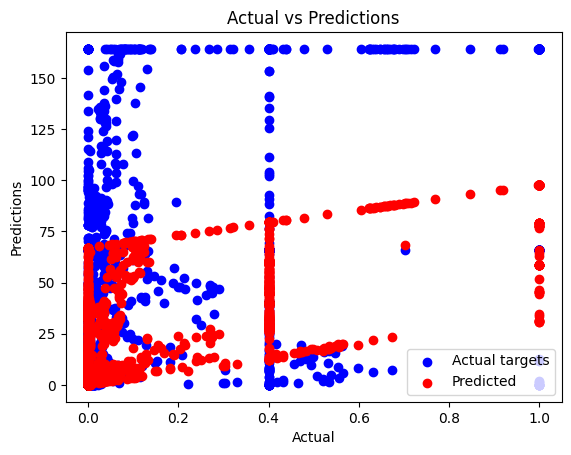

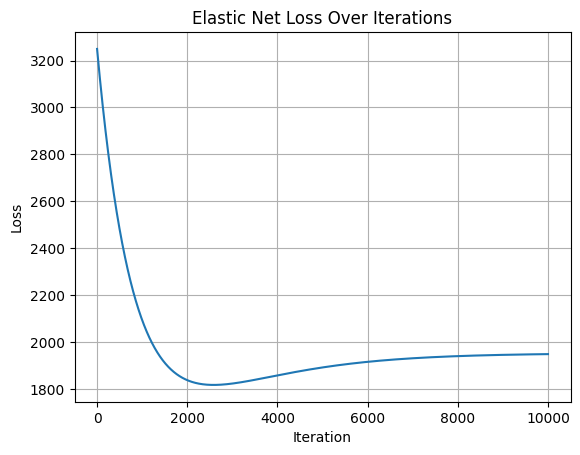

In [56]:
import numpy as np

#using same process as in part 2 logistic regression
loss = []

class ElasticNetRegularization:
  def __init__(self, l1=0.8, l2=0.2, learning_rate=0.001, iterations=10000, tol=1e-4):
    # self.alpha = alpha
    self.l1 = l1
    self.l2 = l2
    self.learning_rate = learning_rate
    self.iterations = iterations
    # self.tol = tol
    self.weights = None

  def fit(self, X, y):
    n_samples, n_features = X.shape
    self.weights = np.zeros((n_features,1)) #b. initalize the weights to zero
    # print(self.weights)

    #using derivative of loss function
    for i in range(self.iterations):
      y_pred = np.dot(X, self.weights)
      # print(y_pred)
      gradient = (-1 * np.dot(X.T , (y - y_pred) ))/ n_samples
      # print(gradient)
      l1_calc = self.l1 * np.sign(self.weights)
      l2_calc = self.l2 * self.weights

      gradient += l1_calc + l2_calc
      self.weights -= self.learning_rate * gradient

      loss_calc = self.loss(X, y)
      loss.append(loss_calc)

      #stopping criteria
      if np.linalg.norm(gradient) < -0.01 or np.linalg.norm(gradient) < 0.01:
        break

  def predict(self, X):
    return np.dot(X, self.weights)

  def loss(self, X, y):
    N = len(y)
    y_pred = np.dot(X, self.weights)
    mse = np.mean((y - y_pred) ** 2)
    l1_calcs = (self.l1 / 2) * np.sum(self.weights ** 2)
    l2_calcs = self.l2 * np.sum(np.abs(self.weights))
    return mse + l1_calcs + l2_calcs


model = ElasticNetRegularization()
model.fit(X_train, y_train)

predictions = model.predict(X_test)

accuracy = np.mean(predictions == y_test) * 100

print("Weights:", model.weights)
print("Predictions:", predictions)
# print(y_test)
print("Accuracy: ", accuracy)
print("Loss Values:", loss)

pickle.dump( model.weights, open( "Rebecca_Abraham_assignment1_part4_1.p", "wb" ) )

plt.scatter(X_test[:,0], y_test, color='blue', label='Actual targets')
plt.scatter(X_test[:, 0], predictions, color='red', label='Predicted')
plt.xlabel("Actual")
plt.ylabel("Predictions")
plt.title("Actual vs Predictions")
plt.legend()
plt.show()

plt.plot(loss)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Elastic Net Loss Over Iterations")
# plt.yscale('log')
plt.grid()


In this the parameters are learning rate = 0.001 and iterations=100000, stoping creiteria that checks the gradient thershold. And using the weights intialized randomly

In [58]:
import numpy as np

#using same process as in part 2 logistic regression
loss = []

class ElasticNetRegularization:
  def __init__(self, l1=0.8, l2=0.2, learning_rate=0.001, iterations=100000, tol=1e-4):
    # self.alpha = alpha
    self.l1 = l1
    self.l2 = l2
    self.learning_rate = learning_rate
    self.iterations = iterations
    # self.tol = tol
    self.weights = None

  def fit(self, X, y):
    n_samples, n_features = X.shape
    self.weights = np.random.uniform(0,1) #a. initalize the weights randomly
    # print(self.weights)

    #using derivative of loss function
    for i in range(self.iterations):
      y_pred = np.dot(X, self.weights)
      # print(y_pred)
      gradient = (-1 * np.dot(X.T , (y - y_pred) ))/ n_samples
      # print(gradient)
      l1_calc = self.l1 * np.sign(self.weights)
      l2_calc = self.l2 * self.weights

      gradient += l1_calc + l2_calc
      self.weights -= self.learning_rate * gradient

      loss_calc = self.loss(X, y)
      loss.append(loss_calc)

      #stopping criteria
      if np.linalg.norm(gradient) < -0.01 or np.linalg.norm(gradient) < 0.01:
        break

  def predict(self, X):
    return np.dot(X, self.weights)

  def loss(self, X, y):
    N = len(y)
    y_pred = np.dot(X, self.weights)
    mse = np.mean((y - y_pred) ** 2)
    l1_calcs = (self.l1 / 2) * np.sum(self.weights ** 2)
    l2_calcs = self.l2 * np.sum(np.abs(self.weights))
    return mse + l1_calcs + l2_calcs


model = ElasticNetRegularization()
model.fit(X_train, y_train)

predictions = model.predict(X_test)

accuracy = np.mean(predictions == y_test) * 100

print("Weights:", model.weights)
print("Predictions:", predictions)
# print(y_test)
print("Accuracy: ", accuracy)
print("Loss Values:", loss)

pickle.dump( model.weights, open( "Rebecca_Abraham_assignment1_part4_2.p", "wb" ) )


Weights: [[30.96453525 30.96453539 30.9645354 ]
 [35.09696068 35.09696055 35.09696068]
 [32.1763754  32.1763754  32.17637527]]
Predictions: [[ 4.81363082  4.8136308   4.81363082]
 [ 5.06702196  5.06702194  5.06702196]
 [ 5.24208065  5.24208063  5.24208065]
 ...
 [98.23787133 98.23787134 98.23787134]
 [98.23787133 98.23787134 98.23787134]
 [98.23787133 98.23787134 98.23787134]]
Accuracy:  0.4294794708812919
Loss Values: [3147.9707762538505, 3146.1137306109595, 3144.2606979056363, 3142.4116725609492, 3140.5666490068206, 3138.725621680016, 3136.888585024137, 3135.055533489611, 3133.2264615336926, 3131.401363620442, 3129.580234220726, 3127.7630678122105, 3125.949858879345, 3124.140601913362, 3122.3352914122684, 3120.5339218808303, 3118.7364878305784, 3116.9429837797848, 3115.1534042534668, 3113.367743783374, 3111.58599690798, 3109.8081581724773, 3108.034222128767, 3106.2641833354514, 3104.4980363578265, 3102.735775767876, 3100.97739614426, 3099.222892072311, 3097.472258144019, 3095.7254889

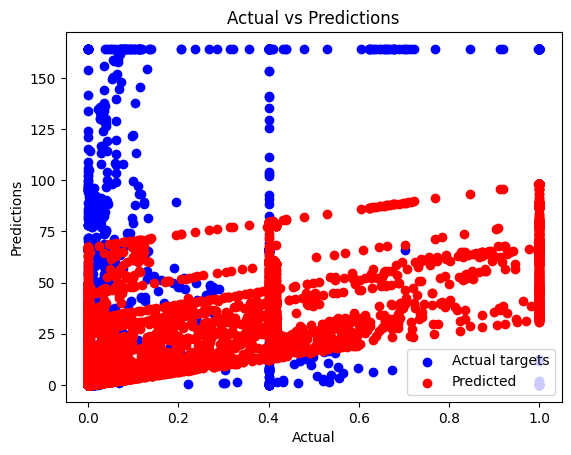

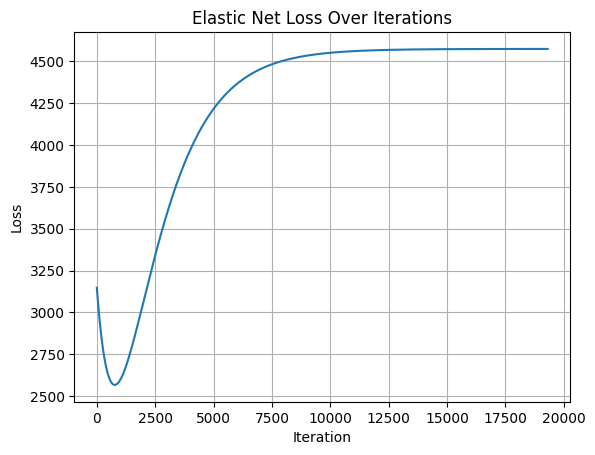

In [59]:
plt.scatter(X_test[:,0], y_test, color='blue', label='Actual targets')
plt.scatter(X_test, predictions, color='red', label='Predicted')
plt.xlabel("Actual")
plt.ylabel("Predictions")
plt.title("Actual vs Predictions")
plt.legend()
plt.show()

plt.plot(loss)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Elastic Net Loss Over Iterations")
# plt.yscale('log')
plt.grid()


In this the parameters are learning rate = 0.0001 and iterations=100000, stoping creiteria that checks the gradient thershold. And using the weights intialized by Xavier intialization

In [60]:
import numpy as np

#using same process as in part 2 logistic regression
loss = []

class ElasticNetRegularization:
  def __init__(self, l1=1, l2=0.5, learning_rate=0.0001, iterations=100000, tol=1e-4):
    # self.alpha = alpha
    self.l1 = l1
    self.l2 = l2
    self.learning_rate = learning_rate
    self.iterations = iterations
    # self.tol = tol
    self.weights = None

  def xavier_initialization(self,input_dim, output_dim):
    # Calculate the limit for uniform distribution
    value = 6 / (input_dim + output_dim)
    limit = np.sqrt( value)

    # Initialize weights with uniform distribution in the range [-limit, limit]
    weights = np.random.uniform(-limit, limit)
    return weights

  def fit(self, X, y):
    n_samples, n_features = X.shape
    self.weights = self.xavier_initialization(len(X), len(X) ) #a. initalize the weights randomly
    # print(self.weights)

    #using derivative of loss function
    for i in range(self.iterations):
      y_pred = np.dot(X, self.weights)
      # print(y_pred)
      gradient = (-1 * np.dot(X.T , (y - y_pred) ))/ n_samples
      # print(gradient)
      l1_calc = self.l1 * np.sign(self.weights)
      l2_calc = self.l2 * self.weights

      gradient += l1_calc + l2_calc
      self.weights -= self.learning_rate * gradient

      loss_calc = self.loss(X, y)
      loss.append(loss_calc)

      #stopping criteria
      if np.linalg.norm(gradient) < -0.01 or np.linalg.norm(gradient) < 0.01:
        break

  def predict(self, X):
    return np.dot(X, self.weights)

  def loss(self, X, y):
    N = len(y)
    y_pred = np.dot(X, self.weights)
    mse = np.mean((y - y_pred) ** 2)
    l1_calcs = (self.l1 / 2) * np.sum(self.weights ** 2)
    l2_calcs = self.l2 * np.sum(np.abs(self.weights))
    return mse + l1_calcs + l2_calcs


model = ElasticNetRegularization()
model.fit(X_train, y_train)

predictions = model.predict(X_test)

accuracy = np.mean(predictions == y_test) * 100

print("Weights:", model.weights)
print("Predictions:", predictions)
# print(y_test)
print("Accuracy: ", accuracy)
print("Loss Values:", loss)



Weights: [[19.84442229 19.84442229 19.84442229]
 [22.42029741 22.42029741 22.42029741]
 [20.99990596 20.99990596 20.99990596]]
Predictions: [[ 3.07507986  3.07507986  3.07507986]
 [ 3.23691402  3.23691402  3.23691402]
 [ 3.34878493  3.34878493  3.34878493]
 ...
 [63.26462566 63.26462566 63.26462566]
 [63.26462566 63.26462566 63.26462566]
 [63.26462566 63.26462566 63.26462566]]
Accuracy:  0.4294794708812919
Loss Values: [3250.963625954785, 3250.7631731220877, 3250.562774321819, 3250.3624295430054, 3250.1621387746713, 3249.9619020058444, 3249.7617192255548, 3249.561590422835, 3249.361515586719, 3249.1614947062453, 3248.9615277704493, 3248.7616147683702, 3248.561755689054, 3248.361950521543, 3248.162199254882, 3247.9625018781203, 3247.762858380311, 3247.5632687505044, 3247.363732977754, 3247.1642510511183, 3246.9648229596537, 3246.7654486924216, 3246.566128238486, 3246.366861586909, 3246.167648726758, 3245.968489647102, 3245.7693843370125, 3245.5703327855604, 3245.3713349818236, 3245.1723

In [61]:
pickle.dump( model.weights, open( "Rebecca_Abraham_assignment1_part4_3.p", "wb" ) )

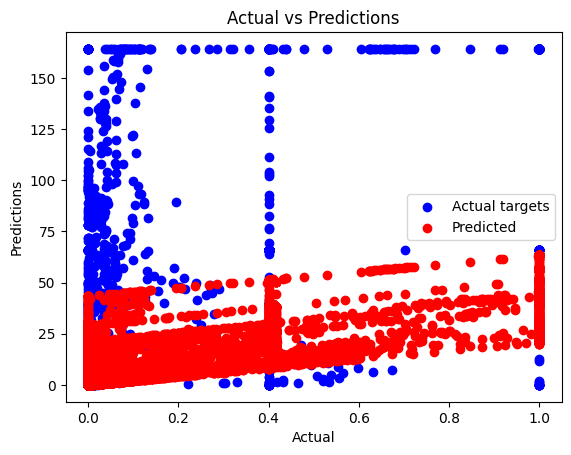

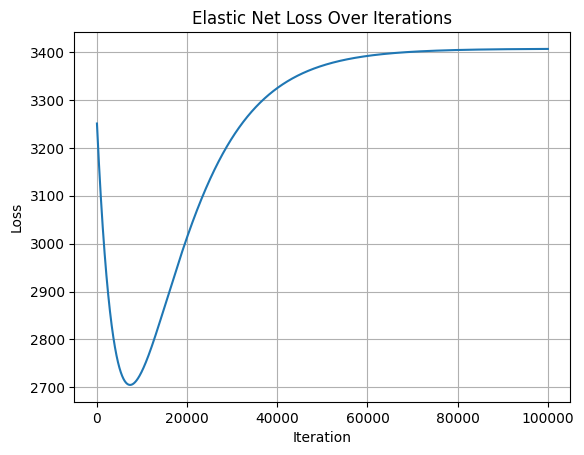

In [62]:
plt.scatter(X_test[:,0], y_test, color='blue', label='Actual targets')
plt.scatter(X_test, predictions, color='red', label='Predicted')
plt.xlabel("Actual")
plt.ylabel("Predictions")
plt.title("Actual vs Predictions")
plt.legend()
plt.show()

plt.plot(loss)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Elastic Net Loss Over Iterations")
# plt.yscale('log')
plt.grid()

References

In [ ]:
# https://numpy.org/doc/stable/reference/routines.linalg.html

In [ ]:
# https://numpy.org/doc/2.1/reference/generated/numpy.c_.html

In [ ]:
# To understand the steps for elastic regression https://www.geeksforgeeks.org/implementation-of-elastic-net-regression-from-scratch/

In [ ]:
# https://www.geeksforgeeks.org/xavier-initialization/